# Introduction

This notebook shows how to create a `Price Matrix`.

Using a forecast of upcoming electricity prices and (optionally) a PV forecast, the value of electricity within a house is calculated.
Because the actual value is dependent on the required power (PV only produces a limited amount of cheap electricity), prices are different for every time step and power. This results in a 2D frame or a Matrix.

An example to explain the reasoning behind the price matrix:

Take a specific moment in time, where the electricity offtake price is 300€/MWh and injection price is 200€/MWh. PV is producing 2kW (or it is forecasted to), and consumption is 3kW. What is the cost of electricity at that time?
If we hadn't consumed the electricity produced by the PV, it would have been injected. Hence, it is valued at the price of injection.

The combined price therefore is equal to: 2/3 * 200€/MWh + 1/3 * 300 €/MWh = 233 €/MWh.

We can calculate this for every time step and every possible power demand, resulting in a Matrix.

# Preparation and Imports

In [1]:
import pandas as pd

In [2]:
# Plotting

from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from src.price_matrix import generate_price_matrix, map_flexibility_signals

# Input data

We need pricing data (offtake & injection) and a PV forecast. Included in this repository are a few sample datasets.

In [4]:
# Let's select a single day to work with

start = pd.Timestamp('20220701', tz='Europe/Brussels')
end = start + pd.Timedelta('1D')

## Prices

In [5]:
# Load the CSV and truncate to our selected period

prices = pd.read_csv(
    'sample_data/sample_prices.csv',
    index_col=0,
    parse_dates=True
).truncate(
    before=start,
    after=end
)

In [6]:
# This data in on 1H basis, but we'd like to work in a 15 min resolution

prices.index = pd.DatetimeIndex(prices.index)
prices = prices.tz_convert('Europe/Brussels')
prices = prices.resample('15min').ffill()

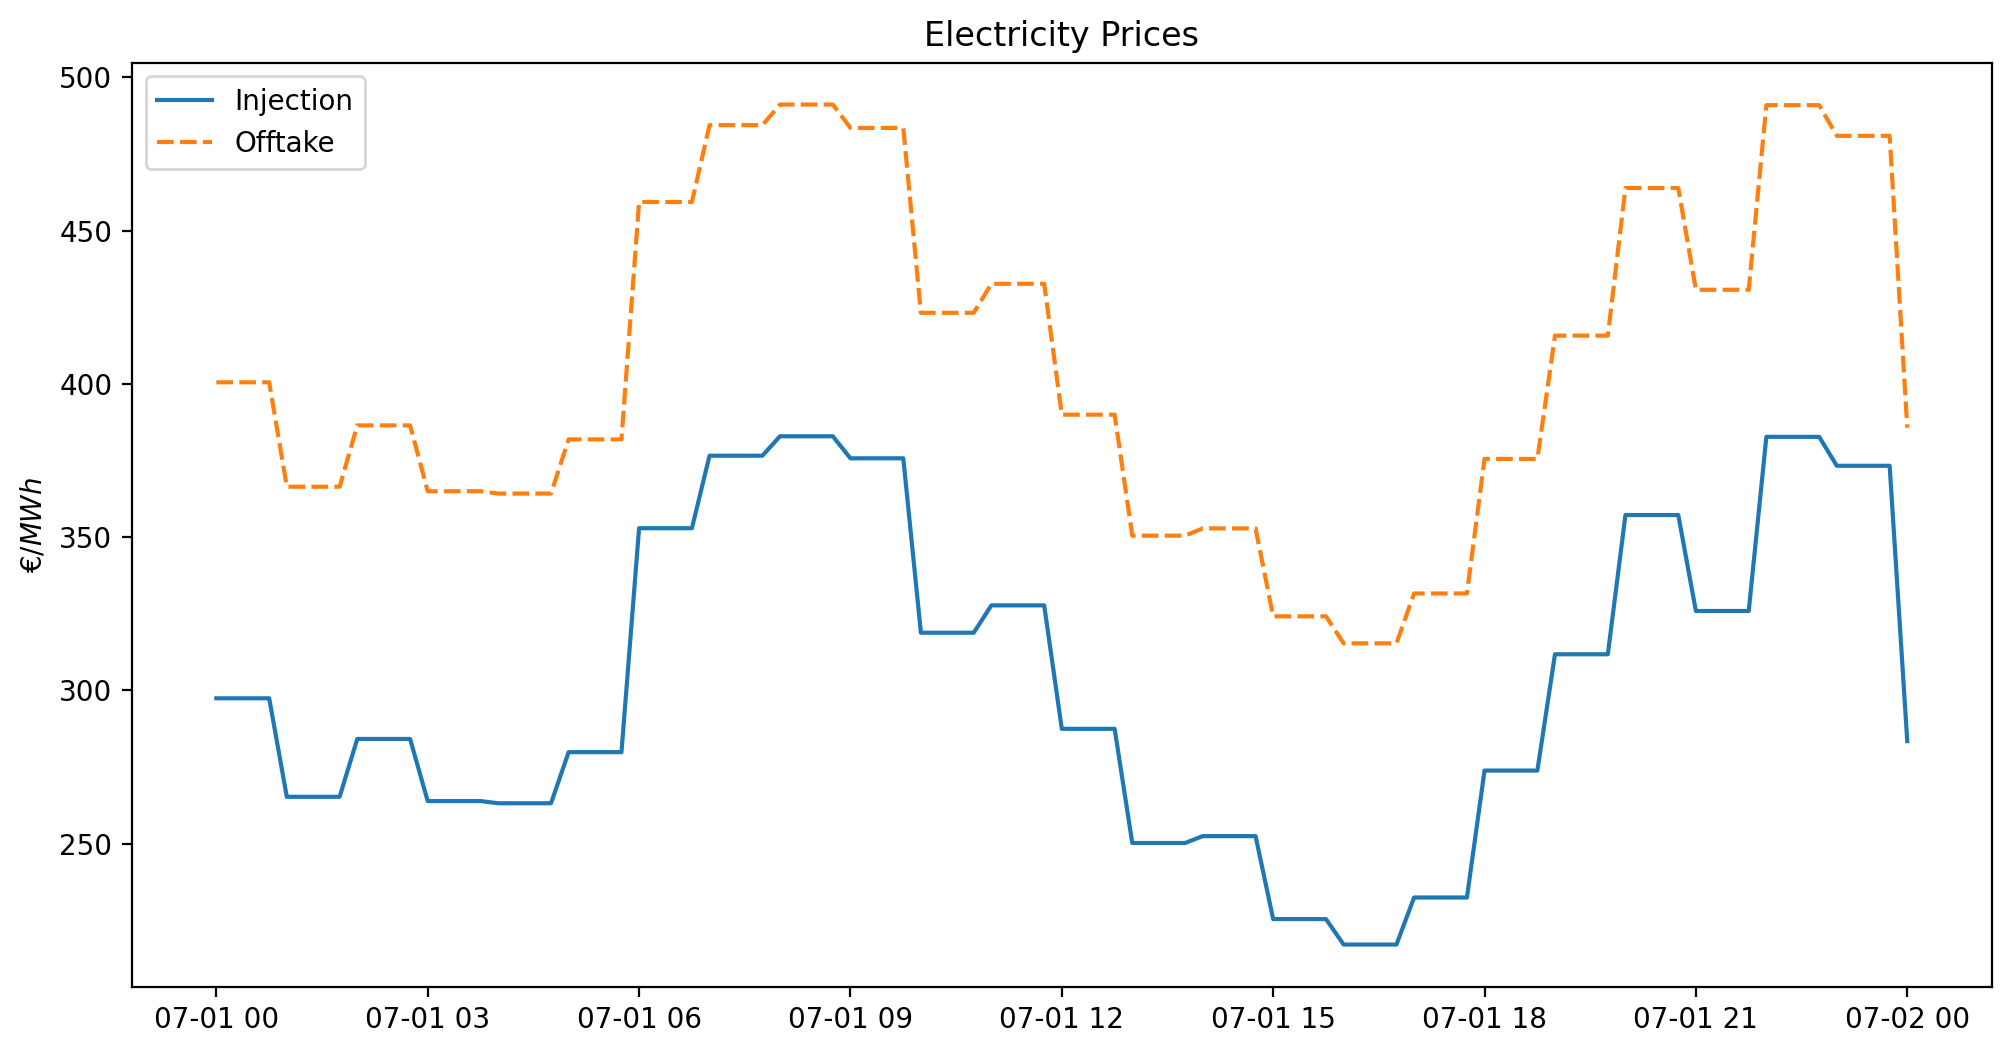

In [7]:
figure(figsize=(12, 6), dpi=200)
sns.lineplot(prices)
plt.ylabel('$€/MWh$')
plt.title('Electricity Prices')
plt.show()

## PV Forecast

As a substitute for a forecast, we can use the sample file of PV-measurements

In [8]:
# Load the CSV and truncate to our selected period

pv_forecast = pd.read_csv(
    'sample_data/pv_power.csv',
    header=None,
    index_col=0,
    parse_dates=True
).squeeze("columns").tz_convert('Europe/Brussels').truncate(
    before=start,
    after=end
)

In [9]:
# The input file is for a 1 kWp system, and the unit is kW.
# We want to simulate a 3 kWp system and have the unit in W, so we multiply by 3000

pv_forecast = pv_forecast * 1000 * 3

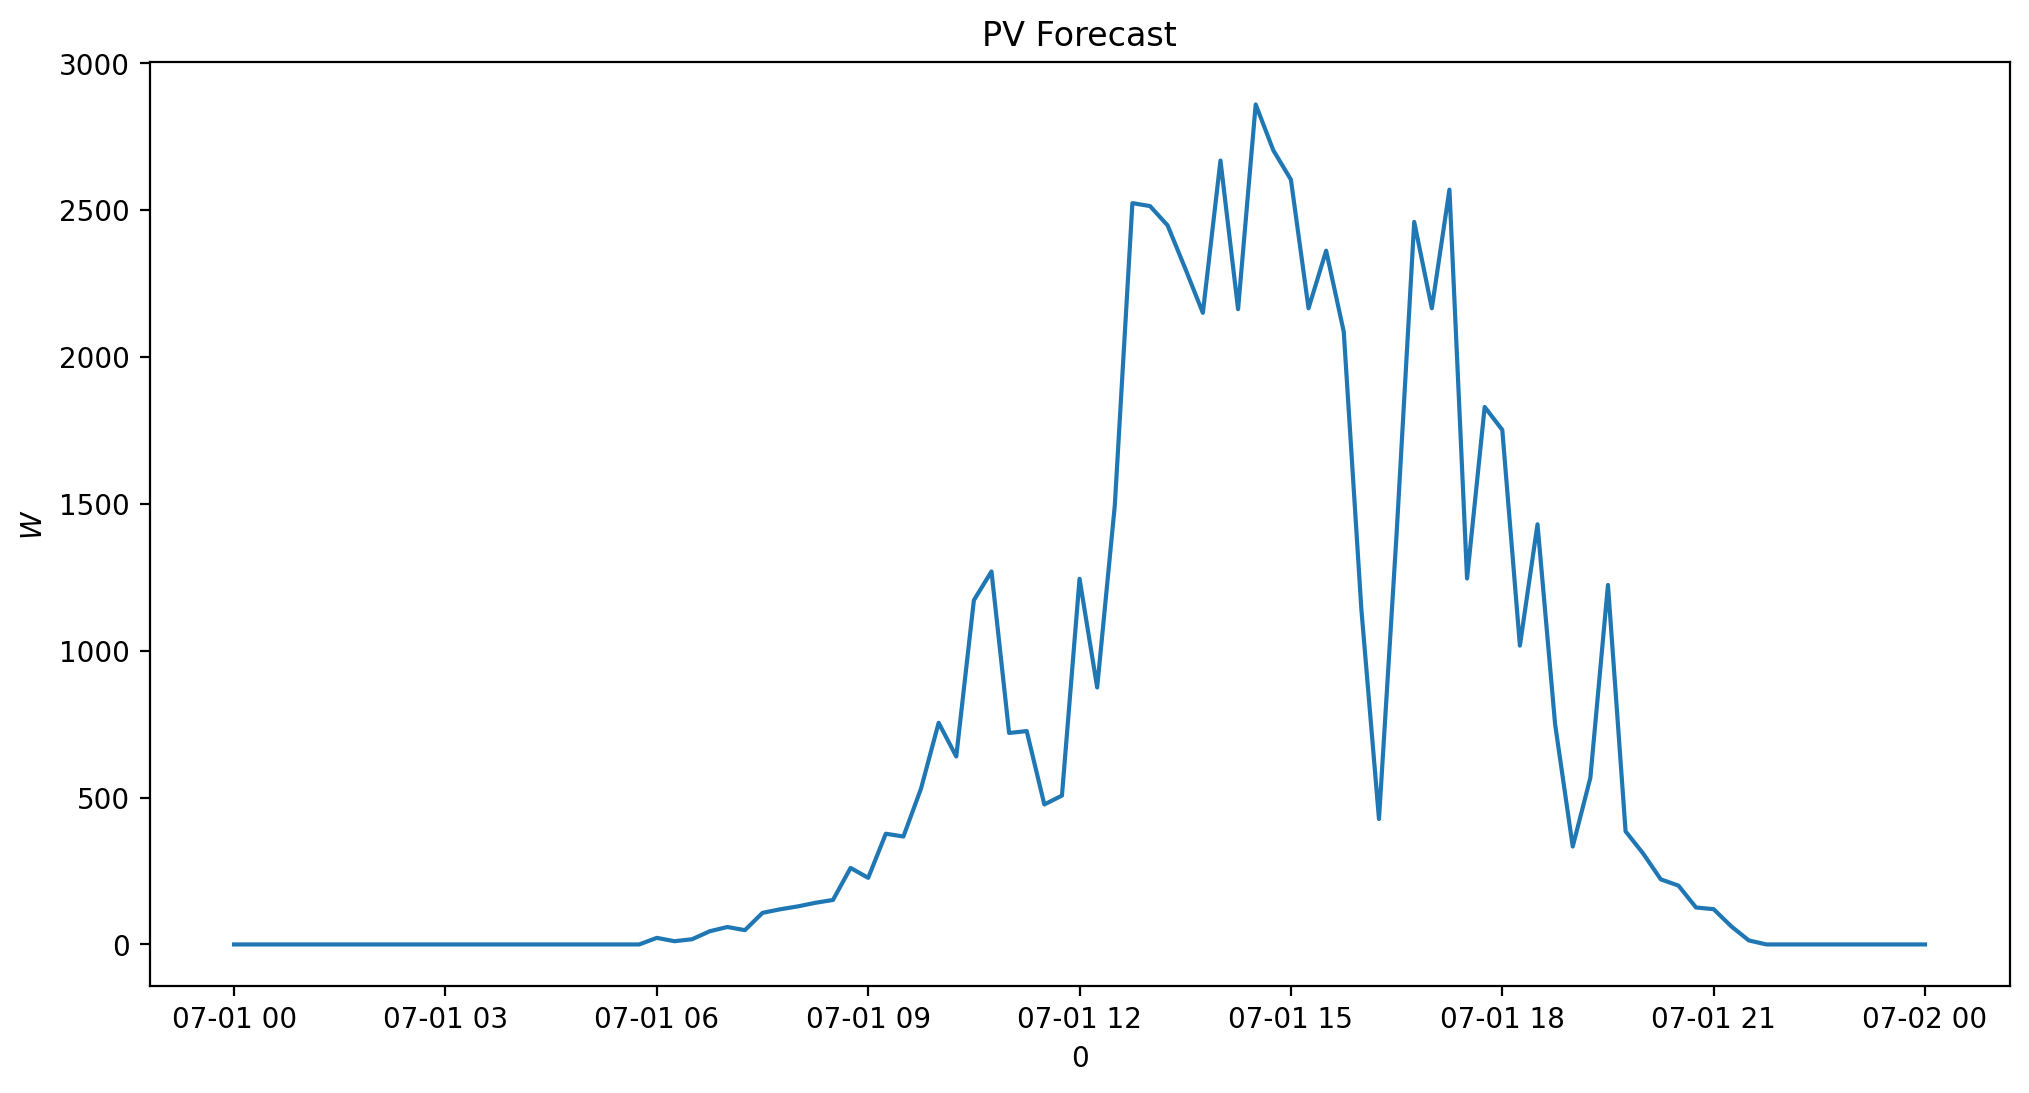

In [10]:
figure(figsize=(12, 6), dpi=200)
sns.lineplot(pv_forecast)
plt.ylabel('$W$')
plt.title('PV Forecast')
plt.show()

# Generate the Price Matrix

In [11]:
matrix = generate_price_matrix(
    offtake_price=prices.Offtake,
    injection_price=prices.Injection,
    pv_forecast=pv_forecast
)

In [12]:
matrix

100         200         300         400   \
2022-07-01 00:00:00+02:00  400.438276  400.469038  400.479292  400.484419   
2022-07-01 00:15:00+02:00  400.438276  400.469038  400.479292  400.484419   
2022-07-01 00:30:00+02:00  400.438276  400.469038  400.479292  400.484419   
2022-07-01 00:45:00+02:00  400.438276  400.469038  400.479292  400.484419   
2022-07-01 01:00:00+02:00  366.371027  366.401214  366.411276  366.416307   
...                               ...         ...         ...         ...   
2022-07-01 23:00:00+02:00  480.846025  480.878712  480.889608  480.895056   
2022-07-01 23:15:00+02:00  480.846025  480.878712  480.889608  480.895056   
2022-07-01 23:30:00+02:00  480.846025  480.878712  480.889608  480.895056   
2022-07-01 23:45:00+02:00  480.846025  480.878712  480.889608  480.895056   
2022-07-02 00:00:00+02:00  385.618898  385.649949  385.660299  385.665475   

                                 500         600         700         800   \
2022-07-01 00:00:00+02:00  400.487495  400.489546  400.491011  400.492110   
2022-07-01 00:15:00+02:00  400.487495  400.489546  400.491011  400.492110   
2022-07-01 00:30:00+02:00  400.487495  400.489546  400.491011  400.492110   
2022-07-01 00:45:00+02:00  400.487495  400.489546  400.491011  400.492110   
2022-07-01 01:00:00+02:00  366.419325  366.421338  366.422775  366.423853   
...                               ...         ...         ...         ...   
2022-07-01 23:00:00+02:00  480.898325  480.900504  480.902061  480.903228   
2022-07-01 23:15:00+02:00  480.898325  480.900504  480.902061  480.903228   
2022-07-01 23:30:00+02:00  480.898325  480.900504  480.902061  480.903228   
2022-07-01 23:45:00+02:00  480.898325  480.900504  480.902061  480.903228   
2022-07-02 00:00:00+02:00  385.668580  385.670650  385.672128  385.673237   

                                 900         1000  ...        4100  \
2022-07-01 00:00:00+02:00  400.492964  400.493648  ...  400.498299   
2022-07-01 00:15:00+02:00  400.492964  400.493648  ...  400.498299   
2022-07-01 00:30:00+02:00  400.492964  400.493648  ...  400.498299   
2022-07-01 00:45:00+02:00  400.492964  400.493648  ...  400.498299   
2022-07-01 01:00:00+02:00  366.424692  366.425363  ...  366.429927   
...                               ...         ...  ...         ...   
2022-07-01 23:00:00+02:00  480.904136  480.904862  ...  480.909805   
2022-07-01 23:15:00+02:00  480.904136  480.904862  ...  480.909805   
2022-07-01 23:30:00+02:00  480.904136  480.904862  ...  480.909805   
2022-07-01 23:45:00+02:00  480.904136  480.904862  ...  480.909805   
2022-07-02 00:00:00+02:00  385.674100  385.674790  ...  385.679485   

                                 4200        4300        4400        4500  \
2022-07-01 00:00:00+02:00  400.498335  400.498369  400.498402  400.498433   
2022-07-01 00:15:00+02:00  400.498335  400.498369  400.498402  400.498433   
2022-07-01 00:30:00+02:00  400.498335  400.498369  400.498402  400.498433   
2022-07-01 00:45:00+02:00  400.498335  400.498369  400.498402  400.498433   
2022-07-01 01:00:00+02:00  366.429963  366.429996  366.430028  366.430058   
...                               ...         ...         ...         ...   
2022-07-01 23:00:00+02:00  480.909843  480.909880  480.909914  480.909947   
2022-07-01 23:15:00+02:00  480.909843  480.909880  480.909914  480.909947   
2022-07-01 23:30:00+02:00  480.909843  480.909880  480.909914  480.909947   
2022-07-01 23:45:00+02:00  480.909843  480.909880  480.909914  480.909947   
2022-07-02 00:00:00+02:00  385.679521  385.679556  385.679589  385.679620   

                                 4600        4700        4800        4900  \
2022-07-01 00:00:00+02:00  400.498463  400.498491  400.498518  400.498544   
2022-07-01 00:15:00+02:00  400.498463  400.498491  400.498518  400.498544   
2022-07-01 00:30:00+02:00  400.498463  400.498491  400.498518  400.498544   
2022-07-01 00:45:00+02:00  400.498463  400.498491  400.498518  400.498544   
2022-07-01 01:00:00+02:00  366.4

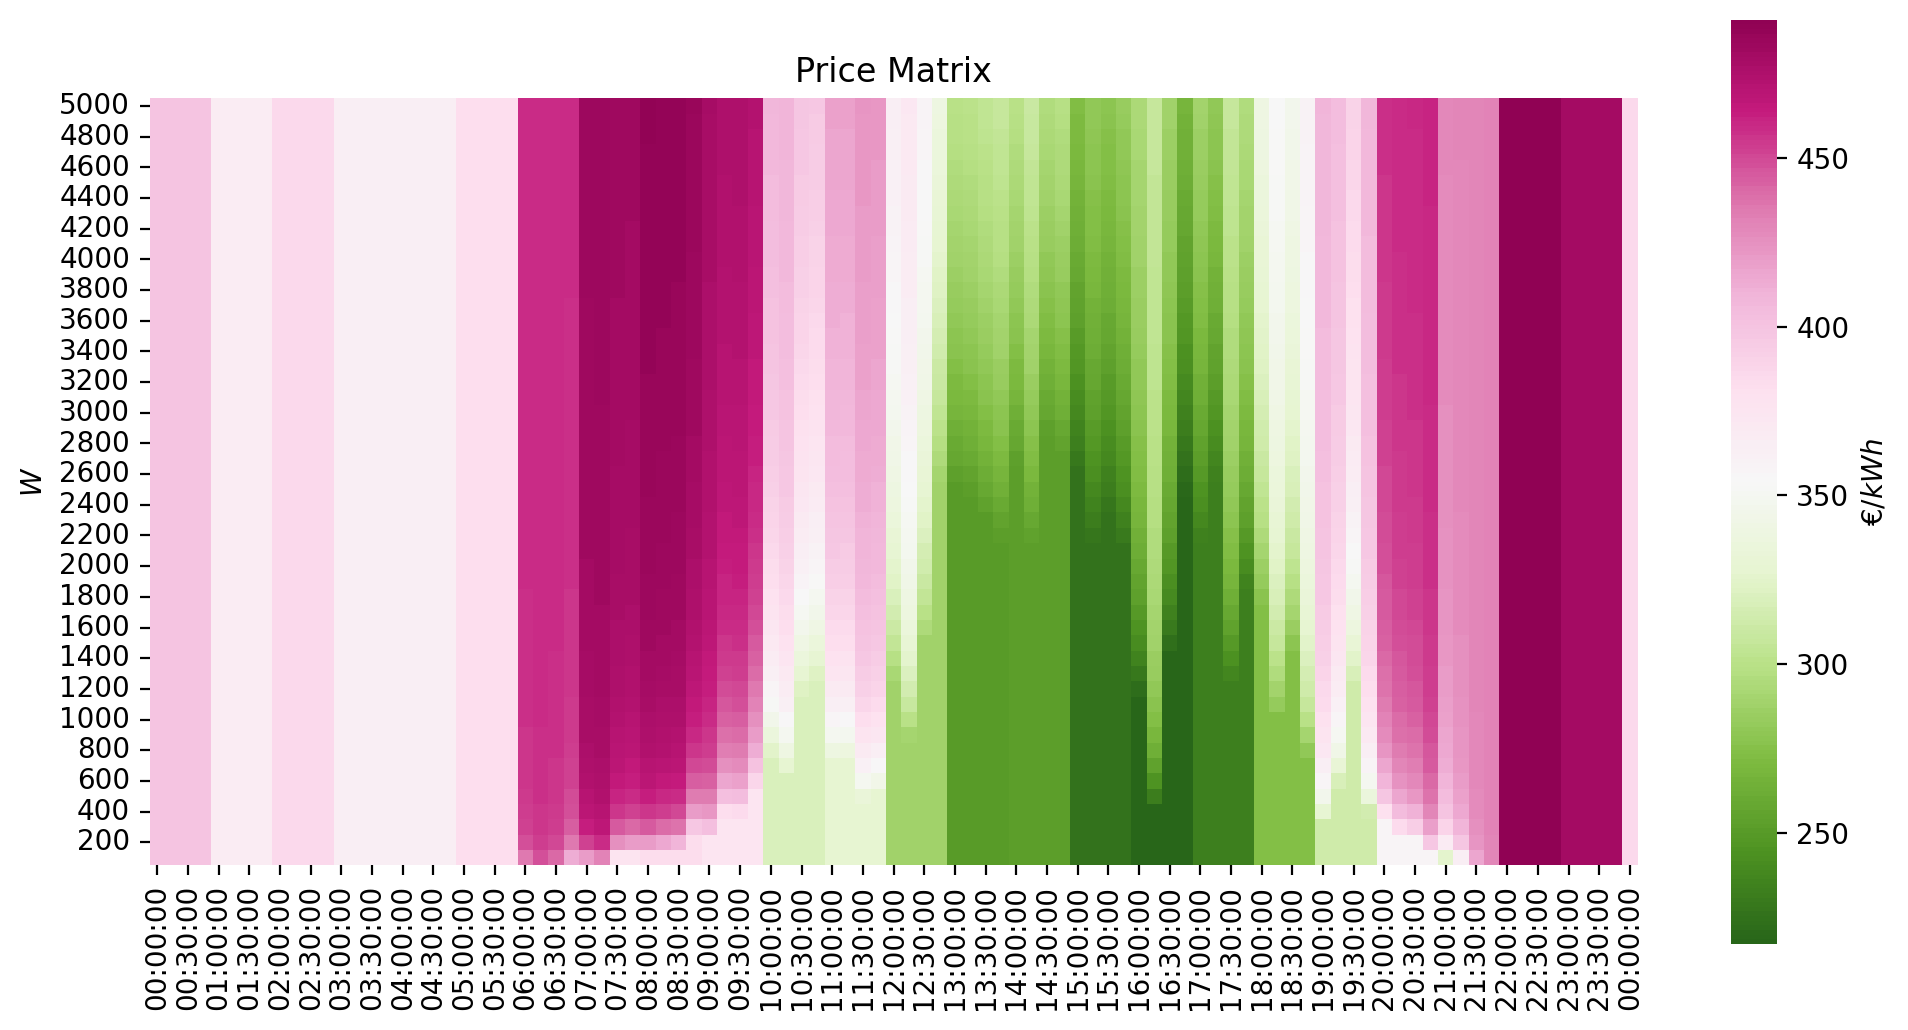

In [13]:
a = matrix.copy()
a.index = a.index.map(lambda x: x.time())

cmap = sns.color_palette("PiYG", 200)
cmap.reverse()

figure(figsize=(12, 6), dpi=200)
sns.heatmap(a.T.sort_index(ascending=False), square=True, cbar_kws={'label': '$€/kWh$'}, cmap=cmap)
plt.ylabel("$W$")
plt.title('Price Matrix')
plt.show()

# Map to Flexibility Signals.

We can map certain values to discrete labels, using percentiles.

In [14]:
mapping = {
    0.25: 1, # Below 25% -> Flex value 1 = augmented consumption
    0.5: 0, # Between 25 and 50% -> Flex value 0 = normal consumption
    0.75: -1, # Between 50 and 75% -> Flex value -1 = reduced consumption
    1.00: -2, # Higher than 75% -> Flex value -2 = blocked consumption
}

In [15]:
signal_matrix = map_flexibility_signals(
    matrix=matrix,
    mapping=mapping,
    map_negative_values_to=2
)

In [16]:
signal_matrix

100   200   300   400   500   600   700   800   \
2022-07-01 00:00:00+02:00    -2    -1    -1    -1    -1    -1    -1    -1   
2022-07-01 00:15:00+02:00    -2    -1    -1    -1    -1    -1    -1    -1   
2022-07-01 00:30:00+02:00    -2    -2    -1    -1    -1    -1    -1    -1   
2022-07-01 00:45:00+02:00    -2    -1    -1    -1    -1    -1    -1    -1   
2022-07-01 01:00:00+02:00    -1    -1    -1     0     0     0     0     0   
...                         ...   ...   ...   ...   ...   ...   ...   ...   
2022-07-01 23:00:00+02:00    -2    -2    -2    -2    -2    -2    -2    -2   
2022-07-01 23:15:00+02:00    -2    -2    -2    -2    -2    -2    -2    -2   
2022-07-01 23:30:00+02:00    -2    -2    -2    -2    -2    -2    -2    -2   
2022-07-01 23:45:00+02:00    -2    -2    -2    -2    -2    -2    -2    -2   
2022-07-02 00:00:00+02:00    -1    -1    -1    -1    -1    -1    -1    -1   

                           900   1000  ...  4100  4200  4300  4400  4500  \
2022-07-01 00:00:00+02:00    -1    -1  ...    -1    -1    -1    -1    -1   
2022-07-01 00:15:00+02:00    -1    -1  ...    -1    -1    -1    -1    -1   
2022-07-01 00:30:00+02:00    -1    -1  ...    -1    -1    -1    -1    -1   
2022-07-01 00:45:00+02:00    -1    -1  ...    -1    -1    -1    -1    -1   
2022-07-01 01:00:00+02:00     0     0  ...     0     0     0     0     0   
...                         ...   ...  ...   ...   ...   ...   ...   ...   
2022-07-01 23:00:00+02:00    -2    -2  ...    -2    -2    -2    -2    -2   
2022-07-01 23:15:00+02:00    -2    -2  ...    -2    -2    -2    -2    -2   
2022-07-01 23:30:00+02:00    -2    -2  ...    -2    -2    -2    -2    -2   
2022-07-01 23:45:00+02:00    -2    -2  ...    -2    -2    -2    -2    -2   
2022-07-02 00:00:00+02:00    -1    -1  ...     0     0     0     0     0   

                           4600  4700  4800  4900  5000  
2022-07-01 00:00:00+02:00    -1    -1    -1    -1    -1  
2022-07-01 00:15:00+02:00    -1    -1    -1    -1    -1  
2022-07-01 00:30:00+02:00    -1    -1    -1    -1    -1  
2022-07-01 00:45:00+02:00    -1    -1    -1    -1    -1  
2022-07-01 01:00:00+02:00     0     0     0     0     0  
...                         ...   ...   ...   ...   ...  
2022-07-01 23:00:00+02:00    -2    -2    -2    -2    -2  
2022-07-01 23:15:00+02:00    -2    -2    -2    -2    -2  
2022-07-01 23:30:00+02:00    -2    -2    -2    -2    -2  
2022-07-01 23:45:00+02:00    -2    -2    -2    -2    -2  
2022-07-02 00:00:00+02:00     0     0     0     0     0  

[97 rows x 50 columns]

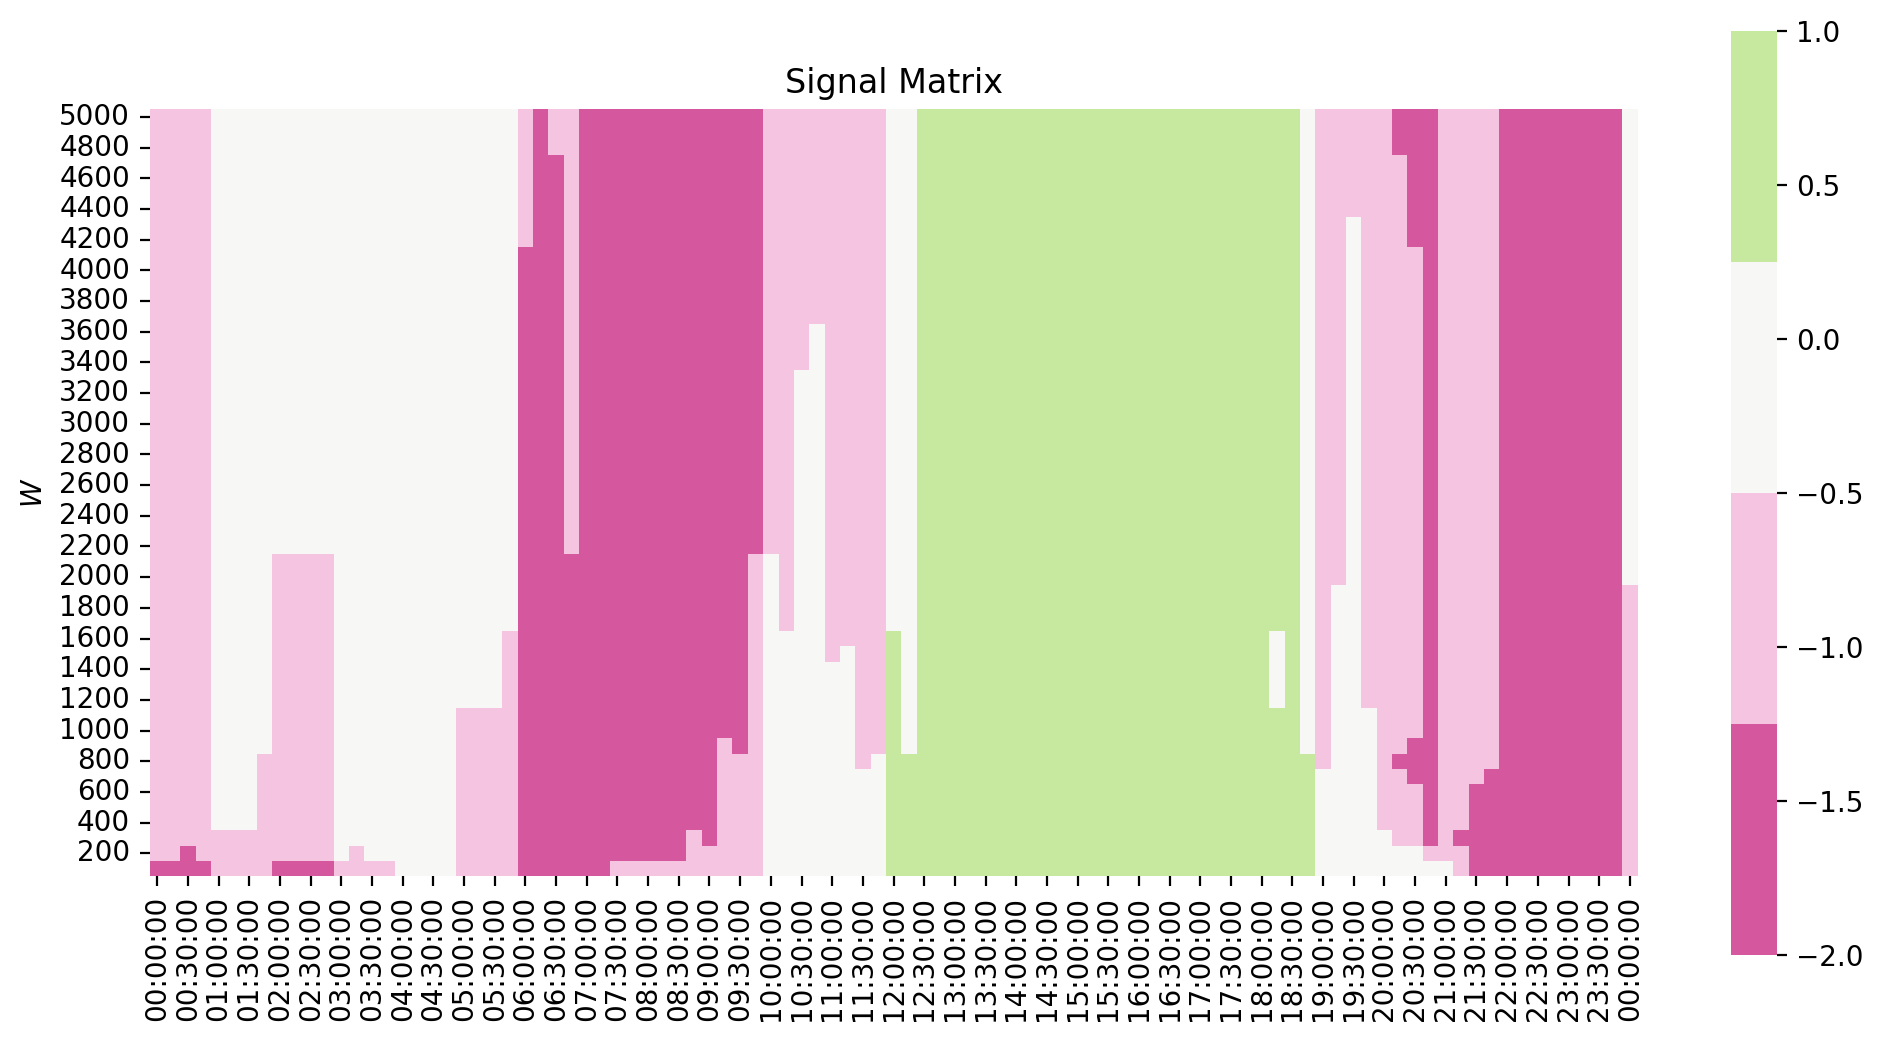

In [17]:
from itertools import chain

a = signal_matrix.copy()
a.index = a.index.map(lambda x: x.time())

cmap = sns.color_palette("PiYG", 5)

# Check if `2` appears in the frame. If not, we remove the dark green from the cmap
uniques = [signal_matrix[column].unique() for column in signal_matrix]
unique = set(chain(*uniques))
if 2 not in unique:
    cmap = cmap[:4]

figure(figsize=(12, 6), dpi=200)
sns.heatmap(a.T.sort_index(ascending=False), square=True, cmap=cmap)
plt.ylabel("$W$")
plt.title('Signal Matrix')
plt.show()